Let's import our packages

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from fbprophet import Prophet

plt.style.use('fivethirtyeight') # Use five thirty eight plotting style
plt.rcParams['axes.facecolor'] = 'white' # Set plot backgrounds to white

C:\Users\asher\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Download our dataset with responses and predictors.

In [2]:
predPath = r"C:\Users\asher\Documents\GitHub\data602-finalproject\predictorsDF.csv"
predictorsDF = pd.read_csv(predPath, index_col = 0)
predictorsDF["logPrecip"] = np.log(predictorsDF["Precip"]+1) # Add a log(precipitation) column

Indx = [] # Index to hold dates
for i in range(len(predictorsDF)): 
    # Convert strings containing dates (eg '2012-10-03') to date objects
    Indx.append(datetime.strptime(predictorsDF.index[i], '%Y-%m-%d').date())
predictorsDF.index = Indx

In [3]:
predictorsDF.columns

Index(['BGT', 'Broad', 'Elliot', 'Fremont', 'MTS', 'NW58', 'Second', 'Spokane',
       'Thirty', 'TwoSix', 'TempHi', 'TempAvg', 'TempLow', 'DewHigh', 'DewAvg',
       'DewLow', 'HumidHi', 'HumidAvg', 'HumidLow', 'PressHigh', 'PressAvg',
       'PressLow', 'VisHigh', 'VisAvg', 'VisLow', 'WindAvg', 'WindLow',
       'WindHigh', 'Precip', 'Events', 'daylightHours', 'logPrecip'],
      dtype='object')

## Data Exploration

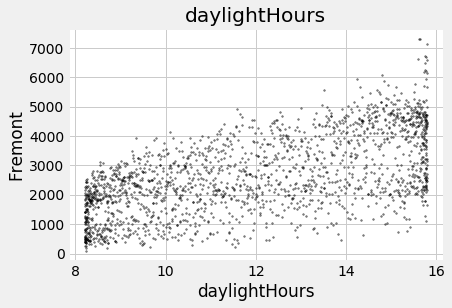

In [6]:
# Create data
predictor = "daylightHours"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

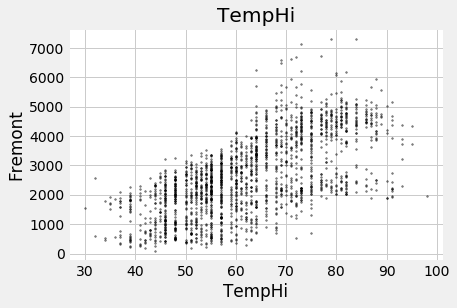

In [7]:
# Create data
predictor = "TempHi"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

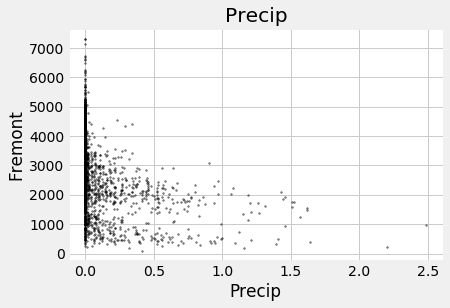

In [8]:
# Create data
predictor = "Precip"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

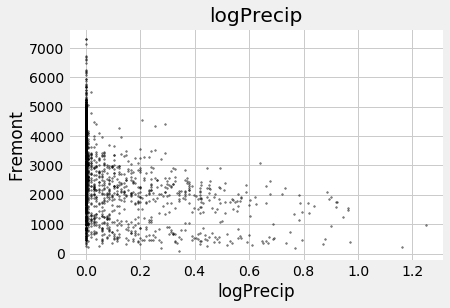

In [9]:
# Create data
predictor = "logPrecip"
counter = "Fremont"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel(predictor)
plt.ylabel(counter)
plt.show()

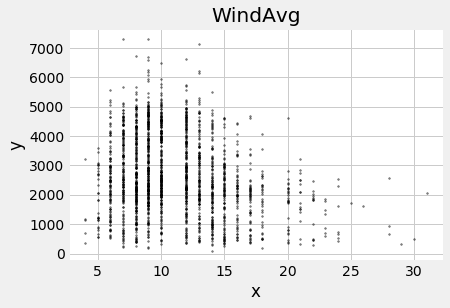

In [11]:
# Create data
predictor = "WindAvg"
x = predictorsDF[predictor]
y = predictorsDF["Fremont"]
colors = (0,0,0)
area = np.pi*1
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title(predictor)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

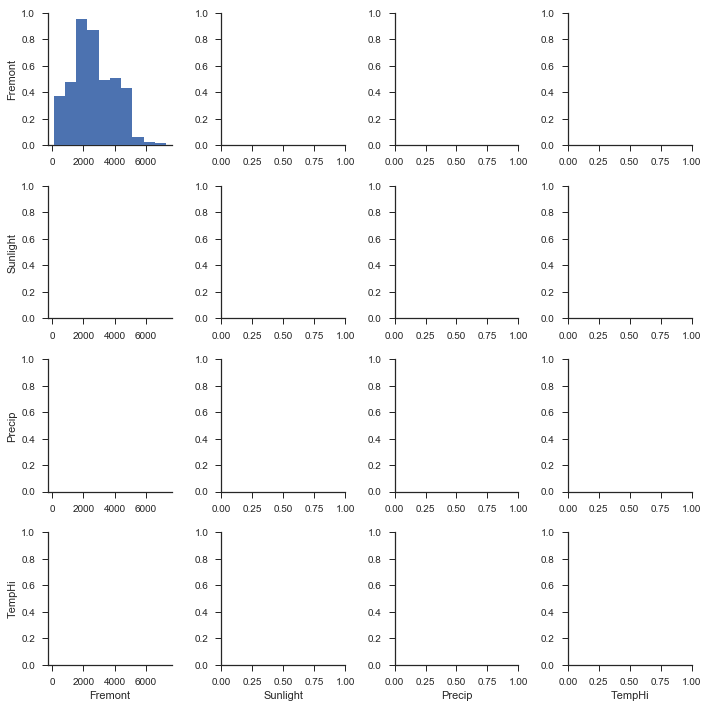

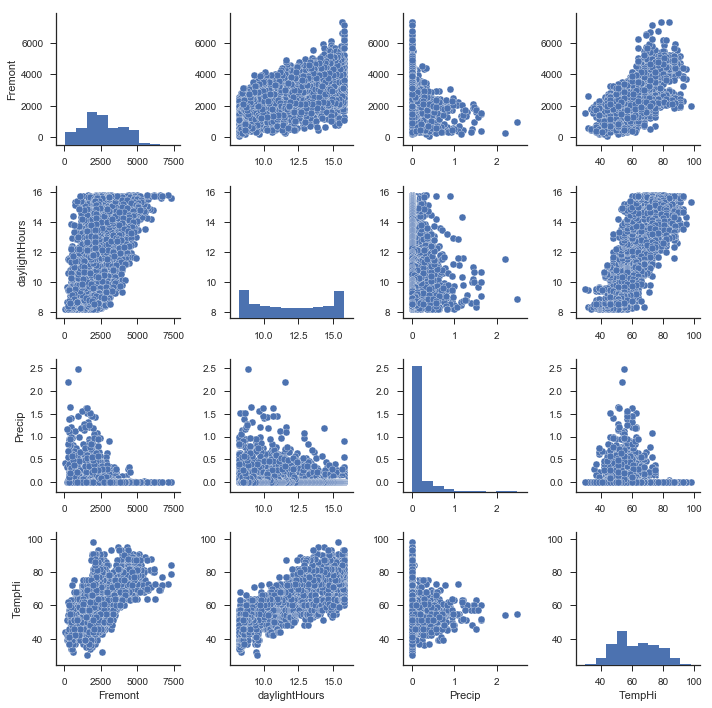

In [13]:
sns.set(style = "ticks")
df = predictorsDF.loc[:,["Fremont", "daylightHours", "Precip", "TempHi"]]
sns.pairplot(df)
plt.show()

## Model Formulation

In [17]:
# Create a list of Prophet forecasts, one series for each counter
Models = []
    
for i in range(11):
        # Start dataframe at each counter with first date counter was active.
        # All counters except Fremont and Second began on 1/1/2014
        if predictorsDF.columns[i] == 'Fremont': k = 0 # 10/3/2012
        elif (predictorsDF.columns[i] == 'Second') | (predictorsDF.columns[i] == 'Total') : 
            k = 820 # 1/1/2015
        else: k = 455    #1/1/2014
        
        df = pd.DataFrame(data = {'ds': predictorsDF.index[k:], # dates
                              'y': predictorsDF.iloc[k:, i], # Counts
                              'logPrecip': predictorsDF['logPrecip'][k:], # log of rainfall in inches
                                 'TempHi': predictorsDF['TempHi'][k:],  # Daily high temperature, Fahrenheit
                                 'cap': max(predictorsDF.iloc[k:, i]),
                                 'floor': min(predictorsDF.iloc[k:, i])}) # Maximum value = maximum observed in dataset
    
        # Create the Prophet Model
        m = Prophet(growth='linear', yearly_seasonality=True, daily_seasonality = False, 
                    weekly_seasonality = True)
        m.add_regressor('logPrecip')
        m.add_regressor('TempHi')
    
        # Fit the Prpohet Model
        m.fit(df)
        Models.append(m)

## Model Prediction

In [20]:
thisDay = datetime.today()
days = 7
date_list = [(thisDay + timedelta(days=x)).date() for x in range(0, days)]

# Compute number of days since last date of actuals, in this case October 31, 2017
#delt = (datetime.today().date() - datetime(2017, 10, 31).date()).days

# Get weather forecast data, to predict upcoming bike counts using weatherbit API, in Imperial measures.
ForecastURL= 'http://api.wunderground.com/api/91468d8e9a46ecc5/forecast10day/q/WA/Seattle.json'
forecastJSON = pd.read_json(ForecastURL) # Read in the JSON data from API call
logPrecip = [] # list to house rainfall forecasts
TempHi = []
for i in range(days): 
    DayDict = forecastJSON.iloc[1, 0]['forecastday'][i] # Identify location in JSON where data appears
    logPrecip.append(np.log(DayDict['qpf_allday']['in'] + 1)) # Add 1 to avoid log of zero
    TempHi.append(int(DayDict['high']['fahrenheit'])) 

# Create dataframe
future = pd.DataFrame({'TempHi': TempHi,
                      'logPrecip': logPrecip,
                      'ds': date_list,
                      'floor': 0,
                      'cap': max(predictorsDF["Fremont"])},
                     index = list(range(days)))

# Create table of forecasts
# Forecasts contains the point estimate forecast, as well as the confidence 
# interval, trend components, and other statistical information about the model
Forecasts = []
ForecastTable = pd.DataFrame({}, index = date_list)
for i in range(10):
    Forecasts.append(Models[i].predict(future))
    ForecastTable[predictorsDF.columns[i]] = Forecasts[i]['yhat'].values# Create column for each counter forecast

ForecastTable = round(ForecastTable)
pd.options.display.float_format = '{:,.0f}'.format

#ForecastTable.columns = counterNames
ForecastTable[ForecastTable < 0 ] = 0 # Set negative values to zero

### View the trend analysis of each counter, in this case Fremont

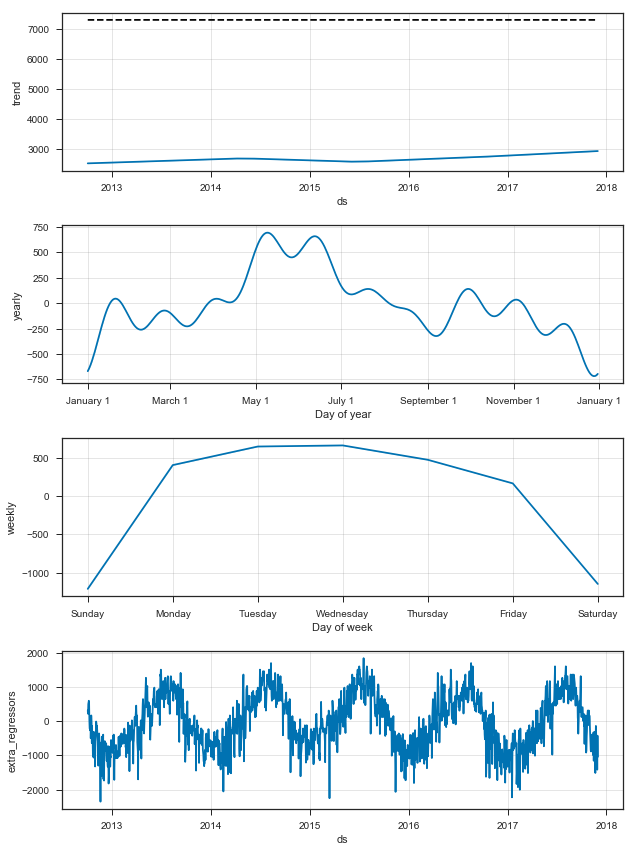

In [21]:
counterNumber = 3
if counterNumber == 3: k = 0 # Fremont, started 10/3/2012
elif (counterNumber == 6) | (counterNumber == 10): k = 820 # Second St, started 1/1/2015
else: k = 455    # All others, started 1/1/2014

future = pd.DataFrame({'TempHi': predictorsDF["TempHi"][k:],
                  'logPrecip': predictorsDF["logPrecip"][k:],
                  'ds': predictorsDF.index[k:],
                  'floor': 0,
                  'cap': max(predictorsDF.iloc[k:, counterNumber][k:])},
                 index = predictorsDF.index[k:])

forecast = Models[counterNumber].predict(future)
Models[counterNumber].plot_components(forecast)

In [22]:
ForecastTable

,BGT,Broad,Elliot,Fremont,MTS,NW58,Second,Spokane,Thirty,TwoSix
2017-12-06,766,292,"1,126","3,171",451,161,757,825,157,81
2017-12-07,534,259,910,"2,745",324,138,688,683,132,55
2017-12-08,441,218,722,"2,291",232,144,577,504,106,20
2017-12-09,818,103,487,"1,112",461,164,88,258,22,0
2017-12-10,802,87,538,"1,085",470,138,60,256,20,0
2017-12-11,616,236,966,"2,689",340,144,625,681,130,41
2017-12-12,527,247,948,"2,769",335,142,707,699,140,53


## Model Validation

### Validation: Creation

In [29]:
# Create a list of Prophet forecasts, one series for each counter
ModelsValidation = []
L = 1855 # Data through October 31, 2017
for i in range(11):
    # Start dataframe at each counter with first date counter was active.
    # All counters except Fremont and Second began on 1/1/2014
    if predictorsDF.columns[i] == 'Fremont': k = 0 # 10/3/2012
    elif predictorsDF.columns[i] == 'Second': k = 820 # 1/1/2015
    else: k = 455    #1/1/2014
    
    df = pd.DataFrame(data = {'ds': predictorsDF.index[k:L], # dates
                          'y': predictorsDF.iloc[k:L, i], # Counts
                          'logPrecip': predictorsDF['logPrecip'][k:L], # log of rainfall in inches
                             'TempHi': predictorsDF['TempHi'][k:L],  # Daily high temperature, Fahrenheit
                             'cap': max(predictorsDF.iloc[k:L, i]),
                             'floor': min(predictorsDF.iloc[k:L, i])}) # Maximum value = maximum observed in dataset

    # Create the Prophet Model
    m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality = True) # Alternatively, growth = 'linear'
    m.add_regressor('logPrecip')
    m.add_regressor('TempHi')

    # Fit the Prpohet Model
    m.fit(df)
    ModelsValidation.append(m)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True t

### Validation: Prediction

In [31]:
# Create the dataframe to house the dates to predict, and their forecasted weather

# Create list of dates, for the next 10 days
FirstOfMonth = datetime(2017,11,1)
MonthLength = 30
date_list = [(FirstOfMonth + timedelta(days=x)).date() for x in range(MonthLength)]
    
# Create dataframe
future = pd.DataFrame({'TempHi': list(predictorsDF["TempHi"][L:]),
                      'logPrecip': list(predictorsDF["logPrecip"][L:]),
                      'ds': date_list,
                      'floor': 0,
                      'cap': max(predictorsDF["Fremont"])},
                     index = date_list)

In [32]:
# Create table of forecasts
FutureCounts = pd.DataFrame({}, index = date_list)
forecasts = []
for i in range(11):
    forecasts.append(ModelsValidation[i].predict(future))
    FutureCounts[predictorsDF.columns[i]] = forecasts[i]["yhat"].values# Create column for each counter forecast
    
FutureCounts = round(FutureCounts)

### Mean Average Percent Error (MAPE)

In [33]:
MAPE = []
for i in range(11):
    name = predictorsDF.columns[i]
    MAPE.append(np.mean(abs(FutureCounts[name] - predictorsDF[name]))/np.mean(predictorsDF[name]))
    
MAPE

[0.17837554125394195,
 0.23492721143159478,
 0.24088395380742644,
 0.15912292886133156,
 0.3238390598795539,
 0.1408459801742187,
 0.2107366413965436,
 0.16388535707814253,
 0.20883979506159656,
 0.3833989807072956,
 0.0]

In [34]:
predictorsDF.iloc[L:, 0:11]

,BGT,Broad,Elliot,Fremont,MTS,NW58,Second,Spokane,Thirty,TwoSix,TempHi
2017-11-01,637,394,"1,383","3,358",385,107,785,917,175,186,55
2017-11-02,520,308,"1,182","2,869",277,112,790,667,188,256,51
2017-11-03,319,259,823,"1,999",1,123,511,442,137,212,44
2017-11-04,324,160,315,765,0,87,153,158,41,74,42
2017-11-05,112,103,130,315,0,22,127,87,27,94,41
2017-11-06,722,369,"1,327","3,222",0,97,758,803,168,157,46
2017-11-07,740,414,"1,346","3,268",0,202,796,870,198,97,48
2017-11-08,571,348,"1,186","2,879",0,90,712,749,188,235,55
2017-11-09,403,296,958,"2,326",0,93,529,567,137,156,50
2017-11-10,602,264,992,"2,408",0,120,699,662,103,32,51


In [1033]:
FutureCounts

,BGT,Broad,Elliot,Fremont,MTS,NW58,Second,Spokane,Thirty,TwoSix
2017-10-01,1166.0,216.0,817.0,2021.0,659.0,150.0,337.0,470.0,72.0,155.0
2017-10-02,999.0,369.0,1258.0,3663.0,543.0,157.0,899.0,904.0,183.0,250.0
2017-10-03,1157.0,411.0,1474.0,4150.0,692.0,181.0,1040.0,1064.0,212.0,284.0
2017-10-04,1178.0,414.0,1464.0,4160.0,693.0,174.0,1046.0,1068.0,203.0,278.0
2017-10-05,1093.0,399.0,1382.0,3961.0,655.0,161.0,1001.0,1003.0,188.0,266.0
2017-10-06,969.0,351.0,1152.0,3439.0,541.0,159.0,864.0,796.0,157.0,233.0
2017-10-07,1143.0,204.0,706.0,1895.0,638.0,155.0,295.0,418.0,49.0,178.0
2017-10-08,1157.0,192.0,773.0,1928.0,663.0,127.0,268.0,428.0,48.0,162.0
2017-10-09,1018.0,346.0,1239.0,3603.0,562.0,141.0,832.0,875.0,162.0,255.0
2017-10-10,801.0,336.0,1087.0,3482.0,478.0,126.0,877.0,815.0,158.0,261.0


In [1082]:
histPath = r"C:\Users\asher\Documents\GitHub\data602-finalproject\histDF.csv"
histDF = pd.read_csv(histPath, index_col = 0)

Indx = [] # Index to hold dates
for i in range(len(histDF)): 
    # Convert strings containing dates (eg '2012-10-03') to date objects
    Indx.append(datetime.strptime(histDF.index[i], '%m/%d/%Y %H:%M'))
histDF.index = Indx

k = 0
L = len(histDF)
i = 3
df = pd.DataFrame(data = {'ds': histDF.index[k:L].values, # dates
                          'y': histDF.iloc[k:L, i].values, # Counts
                          # 'logPrecip': predictorsDF['logPrecip'][k:L].values, # log of rainfall in inches
                         #'TempHi': predictorsDF['TempHi'][k:L].values
                          'cap': max(histDF.iloc[k:L, i]),
                          'floor': 0
                         })  # Daily high temperature, Fahrenheit

ModelsHourly = []

# Create the Prophet Model
m = Prophet(growth='linear', yearly_seasonality=True, weekly_seasonality = True, daily_seasonality=True) 
#m.add_regressor('logPrecip')
#m.add_regressor('TempHi')

# Fit the Prpohet Model
m.fit(df)
ModelsHourly.append(m)

    
# Create dataframe
future = pd.DataFrame({#'TempHi': list(predictorsDF["TempHi"][1824:]),
                      #'logPrecip': list(predictorsDF["logPrecip"][1824:]),
                      'ds': histDF.index,
                      'floor': 0,
                      'cap': max(histDF["Fremont"])},
                     index = histDF.index)



In [1084]:
FutureCounts = pd.DataFrame({}, index = date_list)
forecast = ModelsHourly[0].predict(future)
forecast.index = forecast['ds']
HourlyPred = forecast.iloc[43776:, 22:].resample('1D').sum()

In [1124]:
predictorsDF["Fremont"][1824:].values

array([ 1378.,  3932.,  4417.,  4239.,  4173.,  3574.,  1251.,  1389.,
        3957.,  3318.,  3339.,  2712.,  2742.,  1366.,  1761.,  3921.,
        2746.,  2301.,  2167.,  2291.,   452.,  1285.,  3940.,  4151.,
        3432.,  3549.,  3520.,  1814.,  1218.,  3944.,  3864.])

In [1136]:
list(HourlyPred.values) - predictorsDF.values

ValueError: operands could not be broadcast together with shapes (31,1) (1855,38) 

In [1125]:
HourlyPred.values - predictorsDF["Fremont"][1824:].values

array([[  8.44683130e+02,  -1.70931687e+03,  -2.19431687e+03,
         -2.01631687e+03,  -1.95031687e+03,  -1.35131687e+03,
          9.71683130e+02,   8.33683130e+02,  -1.73431687e+03,
         -1.09531687e+03,  -1.11631687e+03,  -4.89316870e+02,
         -5.19316870e+02,   8.56683130e+02,   4.61683130e+02,
         -1.69831687e+03,  -5.23316870e+02,  -7.83168702e+01,
          5.56831298e+01,  -6.83168702e+01,   1.77068313e+03,
          9.37683130e+02,  -1.71731687e+03,  -1.92831687e+03,
         -1.20931687e+03,  -1.32631687e+03,  -1.29731687e+03,
          4.08683130e+02,   1.00468313e+03,  -1.72131687e+03,
         -1.64131687e+03],
       [  2.20999549e+03,  -3.44004508e+02,  -8.29004508e+02,
         -6.51004508e+02,  -5.85004508e+02,   1.39954918e+01,
          2.33699549e+03,   2.19899549e+03,  -3.69004508e+02,
          2.69995492e+02,   2.48995492e+02,   8.75995492e+02,
          8.45995492e+02,   2.22199549e+03,   1.82699549e+03,
         -3.33004508e+02,   8.41995492e+02,

In [1107]:
Indx = []
for i in range(len(forecast)): 
    # Convert strings containing dates (eg '2012-10-03') to date objects
    Indx.append(datetime.strptime(forecast['ds'][i], '%Y-%m-%d %H:%M:%S'))
forecast.index = Indx

TypeError: strptime() argument 1 must be str, not Timestamp

In [1100]:
forecast.iloc[43776:, ]

,ds,trend,cap,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
43776,2017-10-01 00:00:00,124.970401,1165.0,124.970401,124.970401,-109.647336,111.961000,-75.724790,-75.724790,-75.724790,...,-122.409635,-122.409635,-122.409635,-62.855313,-62.855313,-62.855313,16.170469,16.170469,16.170469,2.560766
43777,2017-10-01 01:00:00,124.972965,1165.0,124.972965,124.972965,-114.518262,103.238369,-82.797593,-82.797593,-82.797593,...,-129.698987,-129.698987,-129.698987,-63.019342,-63.019342,-63.019342,16.117949,16.117949,16.117949,-4.726022
43778,2017-10-01 02:00:00,124.975529,1165.0,124.975529,124.975529,-147.971666,77.674947,-113.383712,-113.383712,-113.383712,...,-160.281374,-160.281374,-160.281374,-62.962738,-62.962738,-62.962738,16.065076,16.065076,16.065076,-35.305845
43779,2017-10-01 03:00:00,124.978093,1165.0,124.978093,124.978093,-170.322818,58.692253,-138.291029,-138.291029,-138.291029,...,-184.963247,-184.963247,-184.963247,-62.684068,-62.684068,-62.684068,16.011850,16.011850,16.011850,-59.985153
43780,2017-10-01 04:00:00,124.980657,1165.0,124.980657,124.980657,-163.999900,68.740668,-123.975831,-123.975831,-123.975831,...,-170.200909,-170.200909,-170.200909,-62.183352,-62.183352,-62.183352,15.958274,15.958274,15.958274,-45.220251
43781,2017-10-01 05:00:00,124.983222,1165.0,124.983222,124.983222,-91.911002,141.498753,-60.510337,-60.510337,-60.510337,...,-106.068055,-106.068055,-106.068055,-61.462067,-61.462067,-61.462067,15.904348,15.904348,15.904348,18.915166
43782,2017-10-01 06:00:00,124.985786,1165.0,124.985786,124.985786,-3.007800,228.469180,28.762478,28.762478,28.762478,...,-15.910588,-15.910588,-15.910588,-60.523139,-60.523139,-60.523139,15.850073,15.850073,15.850073,109.075198
43783,2017-10-01 07:00:00,124.988350,1165.0,124.988350,124.988350,63.865200,297.366689,102.477679,102.477679,102.477679,...,58.902200,58.902200,58.902200,-59.370930,-59.370930,-59.370930,15.795451,15.795451,15.795451,183.890550
43784,2017-10-01 08:00:00,124.990914,1165.0,124.990914,124.990914,99.215052,332.525717,128.185650,128.185650,128.185650,...,85.914935,85.914935,85.914935,-58.011198,-58.011198,-58.011198,15.740483,15.740483,15.740483,210.905849
43785,2017-10-01 09:00:00,124.993478,1165.0,124.993478,124.993478,66.475015,305.048975,100.609212,100.609212,100.609212,...,59.843328,59.843328,59.843328,-56.451054,-56.451054,-56.451054,15.685170,15.685170,15.685170,184.836806


In [1085]:
forecast

# Create table of forecasts
FutureCounts = pd.DataFrame({}, index = histDF.index)
for i in range(3,4):
    forecast = ModelsHourly[0].predict(future)
    FutureCounts[predictorsDF.columns[i]] = list(forecast['yhat']) # Create column for each counter forecast
    
FutureCounts = round(FutureCounts)



,ds,trend,cap,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,...,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2012-10-03 00:00:00,101.295603,1165.0,101.295603,101.295603,-47.412315,183.752049,-75.724790,-75.724790,-75.724790,...,-36.427219,-36.427219,-36.427219,26.435631,26.435631,26.435631,12.861941,12.861941,12.861941,64.868385
1,2012-10-03 01:00:00,101.296188,1165.0,101.296188,101.296188,-54.302083,181.836800,-82.797593,-82.797593,-82.797593,...,-43.650040,-43.650040,-43.650040,26.355207,26.355207,26.355207,12.792346,12.792346,12.792346,57.646148
2,2012-10-03 02:00:00,101.296773,1165.0,101.296773,101.296773,-87.766213,133.895796,-113.383712,-113.383712,-113.383712,...,-74.373874,-74.373874,-74.373874,26.287357,26.287357,26.287357,12.722481,12.722481,12.722481,26.922899
3,2012-10-03 03:00:00,101.297358,1165.0,101.297358,101.297358,-116.759488,117.593838,-138.291029,-138.291029,-138.291029,...,-99.408266,-99.408266,-99.408266,26.230416,26.230416,26.230416,12.652347,12.652347,12.652347,1.889093
4,2012-10-03 04:00:00,101.297943,1165.0,101.297943,101.297943,-98.350299,126.778499,-123.975831,-123.975831,-123.975831,...,-85.211428,-85.211428,-85.211428,26.182457,26.182457,26.182457,12.581946,12.581946,12.581946,16.086515
5,2012-10-03 05:00:00,101.298528,1165.0,101.298528,101.298528,-37.126948,196.870739,-60.510337,-60.510337,-60.510337,...,-21.857710,-21.857710,-21.857710,26.141347,26.141347,26.141347,12.511280,12.511280,12.511280,79.440818
6,2012-10-03 06:00:00,101.299113,1165.0,101.299113,101.299113,46.948069,278.813033,28.762478,28.762478,28.762478,...,67.307637,67.307637,67.307637,26.104809,26.104809,26.104809,12.440350,12.440350,12.440350,168.606750
7,2012-10-03 07:00:00,101.299698,1165.0,101.299698,101.299698,125.223062,353.241840,102.477679,102.477679,102.477679,...,140.917316,140.917316,140.917316,26.070477,26.070477,26.070477,12.369160,12.369160,12.369160,242.217014
8,2012-10-03 08:00:00,101.300283,1165.0,101.300283,101.300283,163.462173,389.047465,128.185650,128.185650,128.185650,...,166.519316,166.519316,166.519316,26.035957,26.035957,26.035957,12.297710,12.297710,12.297710,267.819599
9,2012-10-03 09:00:00,101.300868,1165.0,101.300868,101.300868,125.652353,359.703874,100.609212,100.609212,100.609212,...,138.834092,138.834092,138.834092,25.998877,25.998877,25.998877,12.226002,12.226002,12.226002,240.134960


In [ ]:
MAPE = []
       
for i in range(3,4):
    name = histDF.columns[i]
    MAPE.append(np.mean(abs(FutureCounts[name] - predictorsDF[name]))/np.mean(predictorsDF[name]))
    
np.mean(MAPE)

In [1073]:
ModelsHourly[0]

In [1061]:
forecast

1165.0